In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from keras.utils import np_utils
import random
from keras.preprocessing import image, sequence
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
images_dir = os.listdir("Flickr8k")

images_path = 'Flickr8k/Flicker8k_Dataset/'
captions_path = 'Flickr8k/Flickr8k_text/Flickr8k.token.txt'
train_path = 'Flickr8k/Flickr8k_text/Flickr_8k.trainImages.txt'
val_path = 'Flickr8k/Flickr8k_text/Flickr_8k.devImages.txt'
test_path = 'Flickr8k/Flickr8k_text/Flickr_8k.testImages.txt'

In [6]:
captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [15]:
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

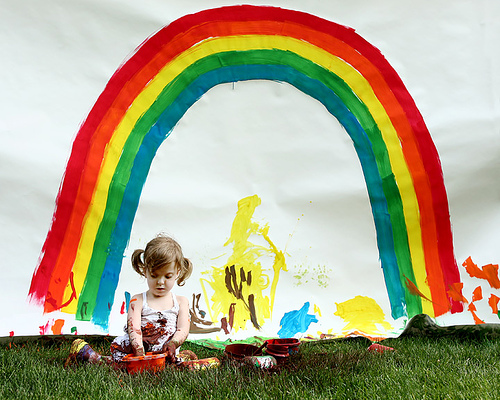

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [18]:
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [19]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [20]:
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [22]:
from IPython.core.display import display, HTML
display(HTML("""<a href="http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006">ResNet50 Architecture</a>"""))
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

94658560/94653016 [==============================] - 174s 2us/step
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________

In [23]:
def preprocessing(img_path):
    im = image.load_img(img_path, target_size=(224,224,3))
    im = image.img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [25]:
len(x_train)

6001

In [26]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1000
2000
3000


In [28]:
train_data['2513260012_03d33305cf.jpg']

array([0.3421216 , 1.2422552 , 0.30413902, ..., 0.18703271, 0.        ,
       0.28812608], dtype=float32)

In [29]:
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )  

In [30]:
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [32]:
type(ds)

numpy.ndarray

In [33]:
pd_dataset.head(10)

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...
5,2903617548_d3e38d7f88.jpg,<start> A little baby plays croquet . <end>
6,2903617548_d3e38d7f88.jpg,<start> A little girl plays croquet next to a ...
7,2903617548_d3e38d7f88.jpg,<start> The child is playing croquette by the ...
8,2903617548_d3e38d7f88.jpg,<start> The kid is in front of a car with a pu...
9,2903617548_d3e38d7f88.jpg,<start> The little boy is playing with a croqu...


In [34]:
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])
    
print(len(sentences))

30000


In [36]:
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [37]:
words = [i.split() for i in sentences]

In [40]:
words

[['<start>',
  'A',
  'black',
  'dog',
  'is',
  'running',
  'after',
  'a',
  'white',
  'dog',
  'in',
  'the',
  'snow',
  '.',
  '<end>'],
 ['<start>',
  'Black',
  'dog',
  'chasing',
  'brown',
  'dog',
  'through',
  'snow',
  '<end>'],
 ['<start>',
  'Two',
  'dogs',
  'chase',
  'each',
  'other',
  'across',
  'the',
  'snowy',
  'ground',
  '.',
  '<end>'],
 ['<start>',
  'Two',
  'dogs',
  'play',
  'together',
  'in',
  'the',
  'snow',
  '.',
  '<end>'],
 ['<start>',
  'Two',
  'dogs',
  'running',
  'through',
  'a',
  'low',
  'lying',
  'body',
  'of',
  'water',
  '.',
  '<end>'],
 ['<start>', 'A', 'little', 'baby', 'plays', 'croquet', '.', '<end>'],
 ['<start>',
  'A',
  'little',
  'girl',
  'plays',
  'croquet',
  'next',
  'to',
  'a',
  'truck',
  '.',
  '<end>'],
 ['<start>',
  'The',
  'child',
  'is',
  'playing',
  'croquette',
  'by',
  'the',
  'truck',
  '.',
  '<end>'],
 ['<start>',
  'The',
  'kid',
  'is',
  'in',
  'front',
  'of',
  'a',
  'car',
  

In [42]:
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [43]:
# Vectorization
word_2_indices = {val:index for index, val in enumerate(unique)}
indices_2_word = {index:val for index, val in enumerate(unique)}

In [47]:
word_2_indices

{'unicycle': 0,
 'vine': 1,
 'kimono': 2,
 'Spectators': 3,
 'pitcher': 4,
 'panes': 5,
 'nightclub': 6,
 'garden': 7,
 'Six': 8,
 'subject': 9,
 'question': 10,
 'seen': 11,
 'adorn': 12,
 'bras': 13,
 'Dinner': 14,
 'sleigh': 15,
 'Thank': 16,
 'trips': 17,
 'headed': 18,
 'streetpole': 19,
 'phrase': 20,
 'grazes': 21,
 'handcrank': 22,
 'designed': 23,
 'ancient': 24,
 'dingo': 25,
 'fiesty': 26,
 'steal': 27,
 'stick': 28,
 'Bum': 29,
 'mansion': 30,
 'arrow': 31,
 'restaraunt': 32,
 'chocolate': 33,
 'nursery': 34,
 'heads': 35,
 'plush': 36,
 'males': 37,
 'glowers': 38,
 'Italy': 39,
 'alone': 40,
 'hamming': 41,
 'novel': 42,
 'flippers': 43,
 'sunshine': 44,
 'sparkling': 45,
 'swordsman': 46,
 'fumble': 47,
 'breaker': 48,
 'lens': 49,
 'gambling': 50,
 'aggresively': 51,
 'squeezed': 52,
 'carrying': 53,
 'tries': 54,
 'backbends': 55,
 'solitude': 56,
 'blond': 57,
 'hairdo': 58,
 'setting': 59,
 'flower-bed': 60,
 'Las': 61,
 'jetskiing': 62,
 'Groucho': 63,
 'halway': 64

In [46]:
word_2_indices['UNK'] = 0
word_2_indices['raining'] = 8253

In [48]:
indices_2_word[0] = 'UNK'
indices_2_word[8253] = 'raining'

In [49]:
print(word_2_indices['<start>'])
print(indices_2_word[4011])
print(word_2_indices['<end>'])
print(indices_2_word[8051])


7197
when
5956
protects


In [50]:
vocab_size = len(word_2_indices.keys())
print(vocab_size)

8254


In [51]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [52]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_2_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = sequence.pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)
    
    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1
        
    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)
    
padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

(30000,)
(30000,)


In [53]:
padded_sequences

array([array([[7197,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [7197, 2035,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [7197, 2035, 1622,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0],
       [7197, 2035, 1622, 8221,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0, 

In [54]:
subsequent_words

array([array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]),
       array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]]),
       array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, Fa

In [55]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_2_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [56]:
num_of_images = 2000

In [57]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [58]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [61]:
with open('train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [83]:
imgs = []

for ix in range(ds.shape[0]):
    
    if ds[ix, 0] in encoded_images.keys():

         imgs.append(list(encoded_images[ds[ix, 0]]))
        
imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [84]:
images = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        images.append(imgs[ix])
        
images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [85]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])
        
image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


In [95]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(captions[0])
print(next_words.shape)


(25493, 40)
[7197.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.]
(25493, 8254)


In [87]:
images = np.load("images.npy")

print(images.shape)

(25493, 2048)


In [88]:
imag = np.load("image_names.npy")
        
print(imag.shape)

(25493,)


In [89]:
embedding_size = 128
max_len = 40

In [90]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               262272    
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 40, 128)           0         
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [91]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           1056512   
_________________________________________________________________
lstm_1 (LSTM)                (None, 40, 256)           394240    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 40, 128)           32896     
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [92]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
embedding_1_input (InputLayer)  (None, 40)           0                                            
__________________________________________________________________________________________________
dense_1_input (InputLayer)      (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 128)      1056512     embedding_1_input[0][0]          
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 128)          262272      dense_1_input[0][0]              
__________________________________________________________________________________________________
lstm_1 (LS

In [93]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=200)

Epoch 1/200
25493/25493 [==============================] - 348s 14ms/step - loss: 5.6915 - acc: 0.0793
Epoch 2/200
25493/25493 [==============================] - 328s 13ms/step - loss: 5.1996 - acc: 0.1117
Epoch 3/200
25493/25493 [==============================] - 367s 14ms/step - loss: 5.0895 - acc: 0.1104
Epoch 4/200
25493/25493 [==============================] - 360s 14ms/step - loss: 5.1124 - acc: 0.0969
Epoch 5/200
25493/25493 [==============================] - 340s 13ms/step - loss: 5.0154 - acc: 0.1051
Epoch 6/200
25493/25493 [==============================] - 346s 14ms/step - loss: 4.8865 - acc: 0.1192
Epoch 7/200
25493/25493 [==============================] - 372s 15ms/step - loss: 4.8947 - acc: 0.1107
Epoch 8/200
25493/25493 [==============================] - 354s 14ms/step - loss: 4.8411 - acc: 0.1158
Epoch 9/200
25493/25493 [==============================] - 400s 16ms/step - loss: 4.7211 - acc: 0.1277
Epoch 10/200
25493/25493 [==============================] - 40324s 2s/ste

KeyboardInterrupt: 